# Multi-axial Lumbar Moment Regression


Primary Goals:
- Evaluate the regression performance for all lumbar axial moments using the historgram-based gradient boosting method 
- Evaluate if/how including the "Mass" information can increase the prediction performance

**NOTE: This notebook requires scikit-learn >=0.21. Use the "conda_cpac" kernel**:
    
    conda create --name cpac --clone python3
    . /home/ec2-user/anaconda3/etc/profile.d/conda.sh
    conda activate cpac
    conda update --all

In [1]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

## Libraries

In [43]:
# Standard library
import os
import re

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, 
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load dataset

In [3]:
#dataset_name = "lumbar_results_PXV_10_15_19.csv" # lab-based targets, lab-based predictors (all trials)
dataset_name = "lumbar_results2_PXV_10_15_19.csv" # lab-based target, wearable predictors (subset of trials)
#dataset_name = "lumbar_results3_PXV_10_15_19.csv" # lab-based targets, lab-based predictors (same subset of trials as above)

df_orig = utils.load_dataset("s3://cpac/ORIG/SpinePredictions_500taks_PXV_1S_10_15_19/" + dataset_name)
df_orig.describe()

Trial_Index_2        Mass_2  Pelvis_Moment_X_2  Pelvis_Moment_Y_2  \
count   91258.000000  91258.000000       88897.000000       88897.000000   
mean     1498.880295      9.770705         -82.856951           6.221593   
std      1184.956952      5.183312          73.010224          30.737168   
min         1.000000      5.000000        -383.737732       -1354.738403   
25%       463.000000      5.000000        -142.227692          -9.199482   
50%      1220.000000     10.000000         -65.825653           4.952320   
75%      2330.000000     15.000000         -15.545347          23.169724   
max      4765.000000     23.000000         331.114929        1069.714722   

       Pelvis_Moment_Z_2  INSOLE_LFORCE  INSOLE_RFORCE   INSOLE_LXMM  \
count       88897.000000   91258.000000   91258.000000  91258.000000   
mean           -4.552406     482.447499     534.089344     56.976953   
std            10.377016     291.051994     305.037610      6.372760   
min          -467.997162       7.720000       0.000000     28.170000   
25%            -8.324476     198.991250     269.228250     54.580000   
50%            -2.700749     495.001000     526.556000     57.760000   
75%             0.239998     732.340250     799.778750     60.430000   
max           907.098022    1239.510000    1331.802000     72.540000   

        INSOLE_LYMM   INSOLE_RXMM  ...      L5S1_Z_1        L4L3_X  \
count  91258.000000  91258.000000  ...  91258.000000  91258.000000   
mean     106.640490     55.502439  ...     -0.115123     -0.123100   
std       48.119794      7.812165  ...      5.681981      0.723665   
min       33.850000      0.000000  ...    -19.151970     -3.288495   
25%       66.020000     51.560000  ...     -4.166251     -0.575576   
50%       93.960000     57.110000  ...     -0.541778     -0.199450   
75%      144.910000     60.420000  ...      4.679438      0.274469   
max      236.040000     76.550000  ...     13.951686      3.651306   

             L4L3_Y        L4L3_Z       L1T12_X       L1T12_Y       L1T12_Z  \
count  91258.000000  91258.000000  91258.000000  91258.000000  91258.000000   
mean       0.406183     -5.873359     -0.123059      0.406197     -0.052926   
std        1.043535      2.524663      0.723638      1.043561      2.524660   
min       -3.861544    -14.354029     -3.288248     -3.861681     -8.533602   
25%       -0.183056     -7.674399     -0.575412     -0.183031     -1.853968   
50%        0.358295     -6.060512     -0.199432      0.358302     -0.240079   
75%        0.997222     -3.745073      0.274424      0.997274      2.075361   
max        4.974982      0.367887      3.651238      4.974470      6.188318   

             T9T8_X        T9T8_Y        T9T8_Z  
count  91258.000000  91258.000000  91258.000000  
mean      -0.122218      0.292773      5.797092  
std        0.568168      0.764885      1.893398  
min       -2.638369     -2.874966     -0.564287  
25%       -0.485966     -0.139258      4.446483  
50%       -0.175457      0.260802      5.656814  
75%        0.205431      0.723043      7.393155  
max        2.774458      3.677700     10.477099  

[8 rows x 44 columns]

## Clean-up dataset

- Associate column types (semi-automatically)
- Eliminate trials start with `"IDP"`
- Eliminate trials containing `"walk"`
- Eliminate samples with missing (`NaN`) values
- Eliminate samples with positive (`>0`) values for `Pelvis_Moment_X`
- ~~Eliminate samples below the `1%` and above the `99%` quantile for `Pelvis_Moment_Y` and `Pelvis_Moment_Z`~~
- Eliminate samples outside of the normal target range for `Pelvis_Moment_Y` (+/-150) and `Pelvis_Moment_Z` (+/-50)

In [4]:
def select_solumns(df):
    """Select target and feature columns"""
    META_PATTERNS = [
        "Trial_Name.*",
        "Trial_Index.*",
        "Trial_Type.*",
        "Mass.*"
    ]

    TARGET_PATTERNS = [
        "Pelvis_Moment_X.*",
        "Pelvis_Moment_Y.*",
        "Pelvis_Moment_Z.*"
    ]
    
    meta_names = []
    feature_names = []
    target_names = []
    
    for column in df.columns:
        kind = feature_names
        for pattern in META_PATTERNS:
            if re.match(pattern, column):
                kind = meta_names
        for pattern in TARGET_PATTERNS:
            if re.match(pattern, column):
                kind = target_names
        kind.append(column)

    return target_names, feature_names, meta_names

target_names, feature_names, meta_names = select_solumns(df_orig)
target_x_name, target_y_name, target_z_name = target_names # HACK!
trial_name = meta_names[0] # HACK!
mass_name = meta_names[-1] # HACK!

df = df_orig.copy()
df = df[~df[trial_name].str.startswith("IDP")]
df = df[~df[trial_name].str.contains("walk")]
df = df.dropna()
df = df[df[target_x_name] <= 0.0]
# for target_name in target_y_name, target_z_name:
#     q_low = df[target_name].quantile(0.01)
#     q_hi  = df[target_name].quantile(0.99)
#     df = df[(df[target_name] < q_hi) & (df[target_name] > q_low)]
df = df[df[target_y_name].between(-150.0, 150.0)]
df = df[df[target_z_name].between(-50.0, 50.0)]

print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of trials: {len(df[trial_name].unique())} (before clean-up: {len(df_orig[trial_name].unique())})", )

df.describe()

Number of samples: 83485 (before clean-up: 91258)
Number of trials: 45 (before clean-up: 49)


Trial_Index_2        Mass_2  Pelvis_Moment_X_2  Pelvis_Moment_Y_2  \
count   83485.000000  83485.000000       83485.000000       83485.000000   
mean     1544.586668      9.626999         -86.518065           6.472851   
std      1176.182434      5.038036          71.159782          30.097075   
min         1.000000      5.000000        -383.737732         -96.271973   
25%       518.000000      5.000000        -144.301834          -9.969075   
50%      1290.000000     10.000000         -72.080505           5.355928   
75%      2373.000000     15.000000         -19.014175          24.692347   
max      4765.000000     23.000000          -0.000725         121.484680   

       Pelvis_Moment_Z_2  INSOLE_LFORCE  INSOLE_RFORCE   INSOLE_LXMM  \
count       83485.000000   83485.000000   83485.000000  83485.000000   
mean           -4.671040     481.967519     535.511173     57.023322   
std             9.314955     296.197156     310.412932      6.459086   
min           -49.854542       7.720000       0.000000     28.170000   
25%            -8.613463     187.030000     253.932000     54.530000   
50%            -2.931641     493.967000     532.660000     57.850000   
75%             0.132725     743.013000     807.815000     60.550000   
max            49.095215    1192.645000    1286.620000     72.540000   

        INSOLE_LYMM   INSOLE_RXMM  ...      L5S1_Z_1        L4L3_X  \
count  83485.000000  83485.000000  ...  83485.000000  83485.000000   
mean     107.648880     55.419664  ...      0.076154     -0.090481   
std       48.384057      7.924036  ...      5.672559      0.716521   
min       35.210000      0.000000  ...    -19.151970     -2.295476   
25%       66.090000     51.320000  ...     -3.964958     -0.558047   
50%       95.760000     57.080000  ...     -0.245025     -0.182468   
75%      147.040000     60.470000  ...      4.888903      0.310664   
max      236.040000     75.010000  ...     13.951686      3.651306   

             L4L3_Y        L4L3_Z       L1T12_X       L1T12_Y       L1T12_Z  \
count  83485.000000  83485.000000  83485.000000  83485.000000  83485.000000   
mean       0.391898     -5.788622     -0.090440      0.391908      0.031809   
std        1.028364      2.520815      0.716492      1.028387      2.520815   
min       -3.861544    -14.354029     -2.295549     -3.861681     -8.533602   
25%       -0.195746     -7.584578     -0.557961     -0.195752     -1.764144   
50%        0.358537     -5.928234     -0.182432      0.358571     -0.107802   
75%        0.984567     -3.651354      0.310651      0.984593      2.169073   
max        4.974982      0.367887      3.651238      4.974470      6.188318   

             T9T8_X        T9T8_Y        T9T8_Z  
count  83485.000000  83485.000000  83485.000000  
mean      -0.096610      0.284589      5.860615  
std        0.562001      0.754014      1.890515  
min       -1.771676     -2.874966     -0.564287  
25%       -0.472271     -0.145242      4.513509  
50%       -0.161440      0.261799      5.755579  
75%        0.237042      0.715154      7.463798  
max        2.774458      3.677700     10.477099  

[8 rows x 44 columns]

In [5]:
df[target_y_name].describe()

count    83485.000000
mean         6.472851
std         30.097075
min        -96.271973
25%         -9.969075
50%          5.355928
75%         24.692347
max        121.484680
Name: Pelvis_Moment_Y_2, dtype: float64

## Train / test partitioning

- Test set: exercises with 5kg weight
- ~~Test set: all samples where `Trial_Name` contains `"freestyle"` (case insensitive)~~
- Train set: all other samples

In [6]:
test_selector = df[trial_name].str.match("S0[0-9]_5kg")
#test_selector = df["Trial_Name"].str.contains("freestyle", case=False)
df_test = df[test_selector]
df_train = df[~test_selector]
print(f"Train set size: {len(df_train)}\nTest set size: {len(df_test)} ({len(df_test) / len(df):.1%})")

Train set size: 70849
Test set size: 12636 (15.1%)


## Train and evaluate boosted tree models


Pelvis_Moment_X_2:
MSE: 369.31
RMSE: 19.22
R^2 Score: 0.901

Pelvis_Moment_Y_2:
MSE: 230.33
RMSE: 15.18
R^2 Score: 0.773

Pelvis_Moment_Z_2:
MSE: 30.63
RMSE: 5.53
R^2 Score: -0.029


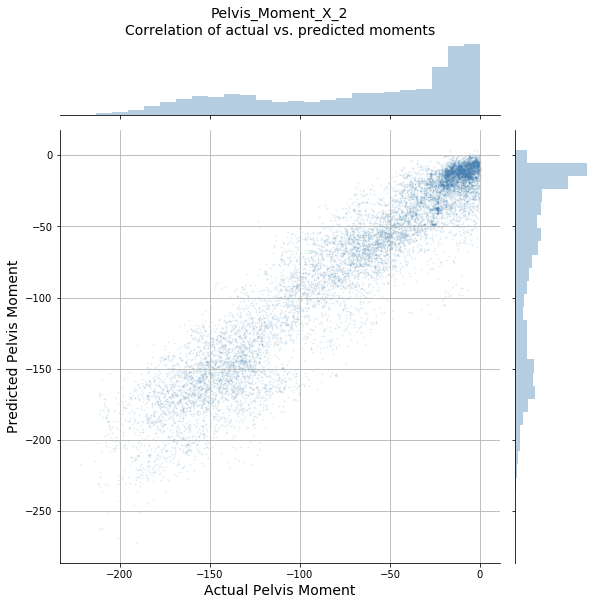

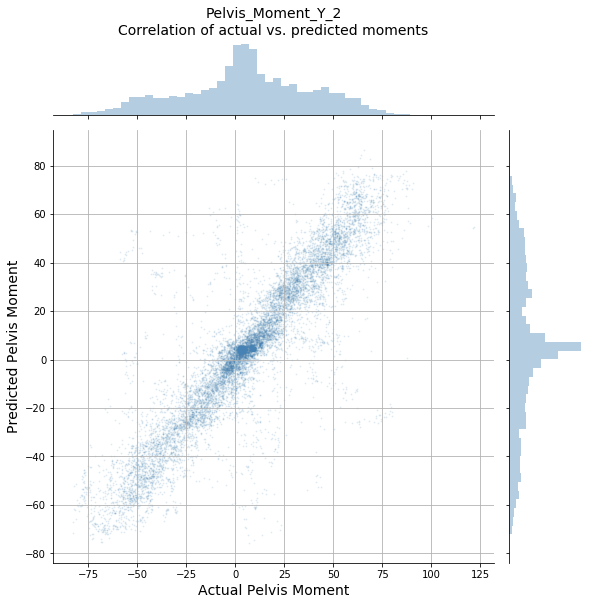

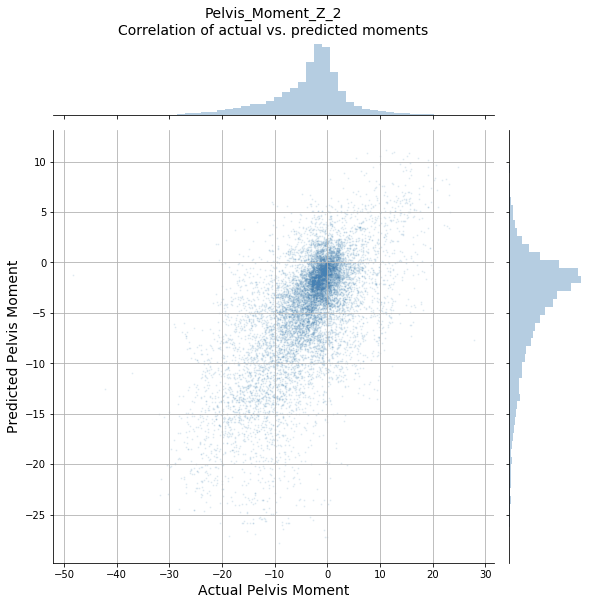

In [7]:
def train_model(X_train, y_train):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor(max_iter=200))
    ]).fit(X_train, y_train)
    return model
    
def evaluate_model(title, model, X_test, y_test):
    
    print(f"\n{title}:")
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    mse = metrics.mean_squared_error(y_test_pred, y_test)
    r2 = metrics.r2_score(y_test_pred, y_test)
    print(f"MSE: {mse:.2f}\nRMSE: {np.sqrt(mse):.2f}\nR^2 Score: {r2:.3f}")
    
    # Correlation plot: actual vs. predicted
    ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color="steelblue", height=8)
    #sns.jointplot(y_test, y_test_pred, kind="hex")
    #sns.jointplot(y_test, y_test_pred, kind="reg")
    ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
    #ax.ax_joint.legend_.remove()
    ax.ax_joint.grid()
    ax.ax_marg_x.set_title(f"{title}\nCorrelation of actual vs. predicted moments", fontsize=14)
    
models = {}
for target_name in target_names:
    model = train_model(df_train[feature_names], df_train[target_name])
    models[target_name] = model
    evaluate_model(target_name,
               model, df_test[feature_names], df_test[target_name])

## Re-train and evaluate with the _mass_ feature


Pelvis_Moment_X_2:
MSE: 314.24
RMSE: 17.73
R^2 Score: 0.910

Pelvis_Moment_Y_2:
MSE: 227.26
RMSE: 15.08
R^2 Score: 0.766

Pelvis_Moment_Z_2:
MSE: 31.25
RMSE: 5.59
R^2 Score: -0.035


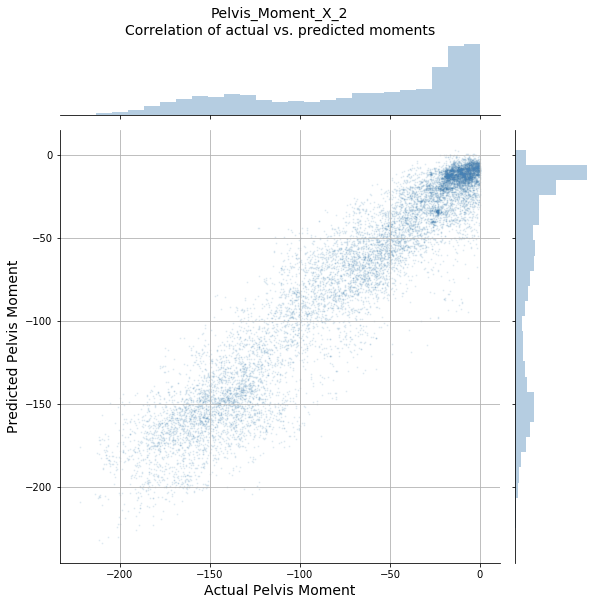

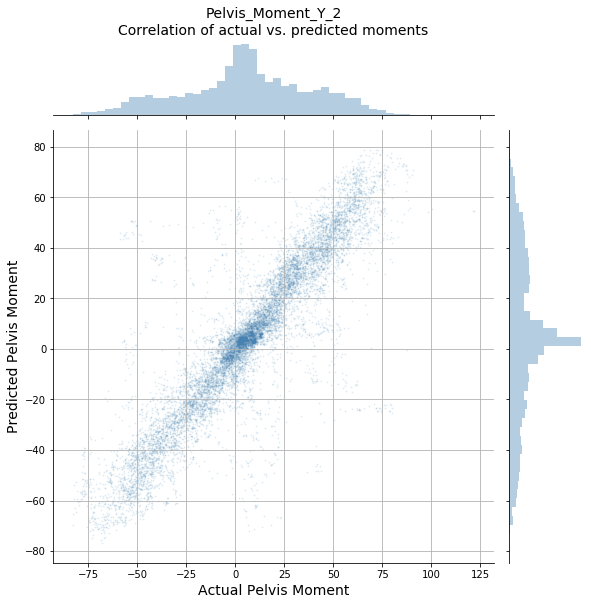

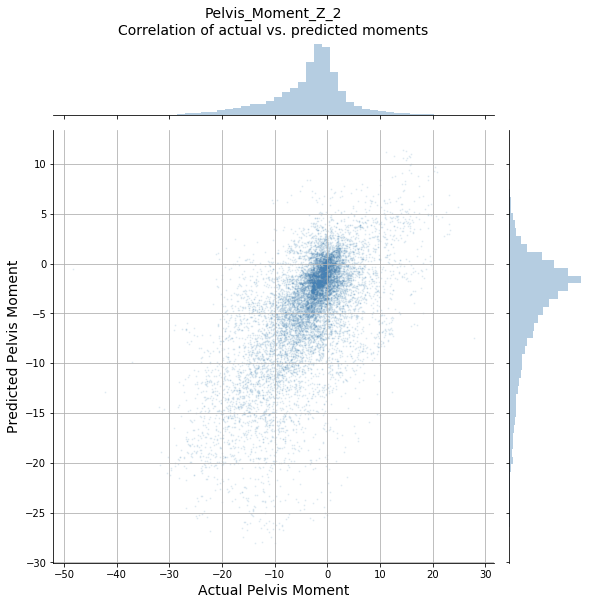

In [8]:
mass_models = {}
mass_feature_names = feature_names + [mass_name]
for target_name in target_names:
    model = train_model(df_train[mass_feature_names], df_train[target_name])
    mass_models[target_name] = model
    evaluate_model(target_name,
               model, df_test[mass_feature_names], df_test[target_name])

## Further experiments with the Z (yaw) moment

- What is the performance of the _mean predictor_?


Pelvis_Moment_Z_2:
MSE: 51.68
RMSE: 7.19
R^2 Score: 0.000


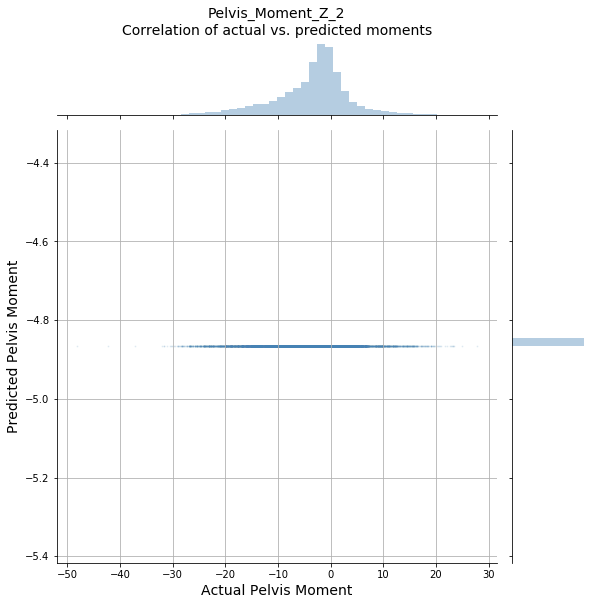

In [10]:
mean_model_z = dummy.DummyRegressor(strategy="mean").fit(df_train[feature_names], df_train[target_z_name])
evaluate_model(target_z_name, mean_model_z, df_test[feature_names], df_test[target_z_name])

- Going back to linear models


Pelvis_Moment_Z_2:
MSE: 45.83
RMSE: 6.77
R^2 Score: -1.065


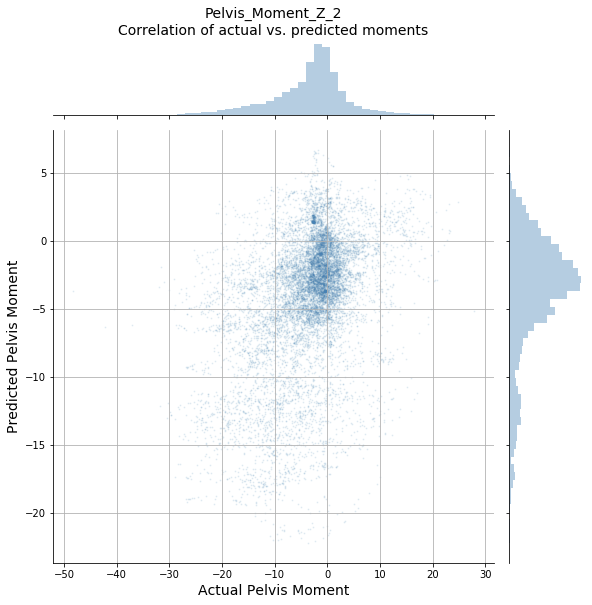

In [13]:
linear_model_z = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('linear', linear_model.LinearRegression())
    ]).fit(df_train[feature_names], df_train[target_z_name])
evaluate_model(target_z_name, linear_model_z, df_test[feature_names], df_test[target_z_name])

- Plot the actual (target) moments for the target set

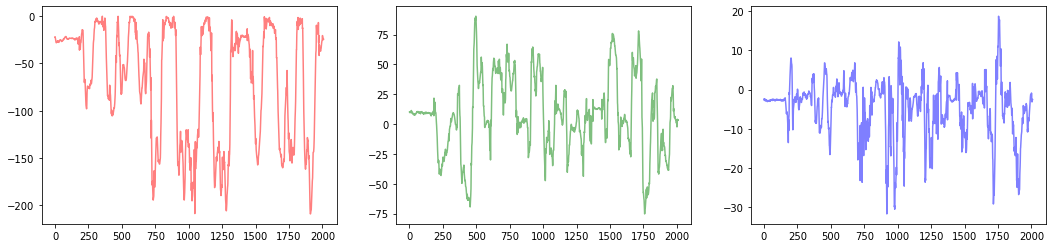

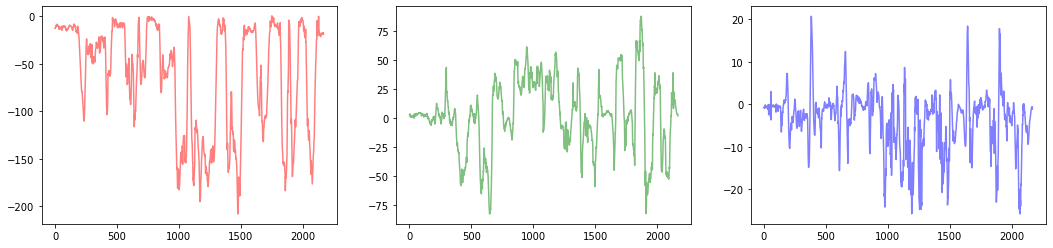

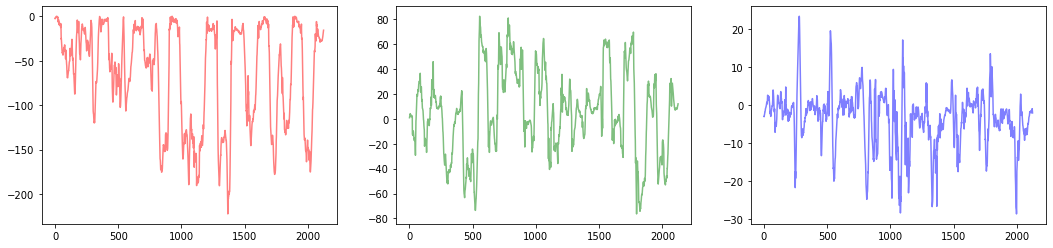

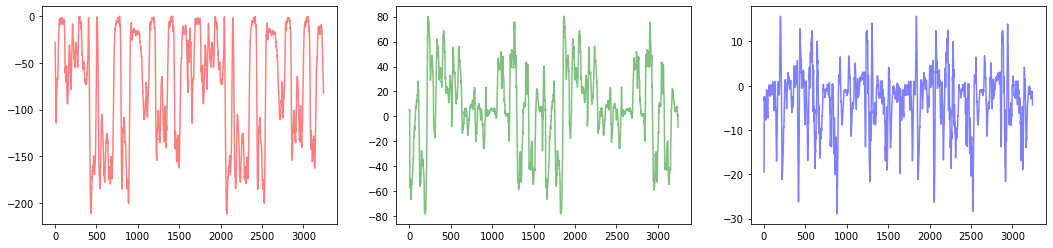

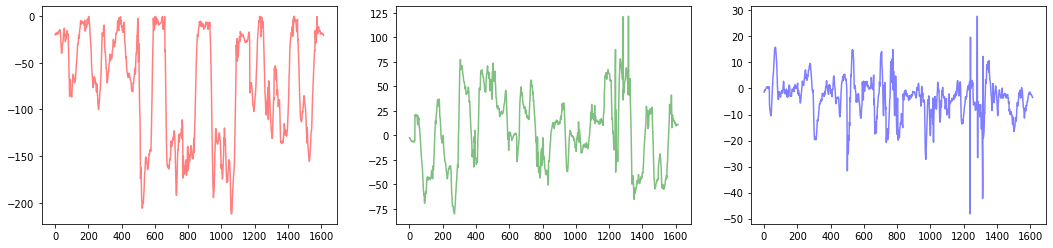

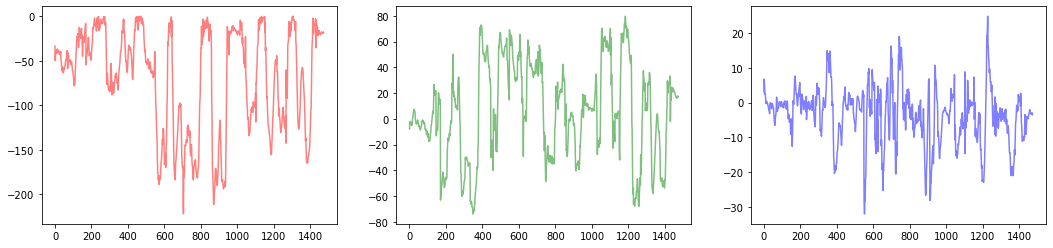

In [31]:
for trial, trial_df in df_test.groupby(trial_name):
    plt.figure(figsize=(18, 4))
    plt.subplot(1, 3, 1)
    plt.plot(trial_df[target_x_name].values, "r", alpha=0.5)
    plt.subplot(1, 3, 2)
    plt.plot(trial_df[target_y_name].values, "g", alpha=0.5)
    plt.subplot(1, 3, 3)
    plt.plot(trial_df[target_z_name].values, "b", alpha=0.5)


- Correlation with individual features

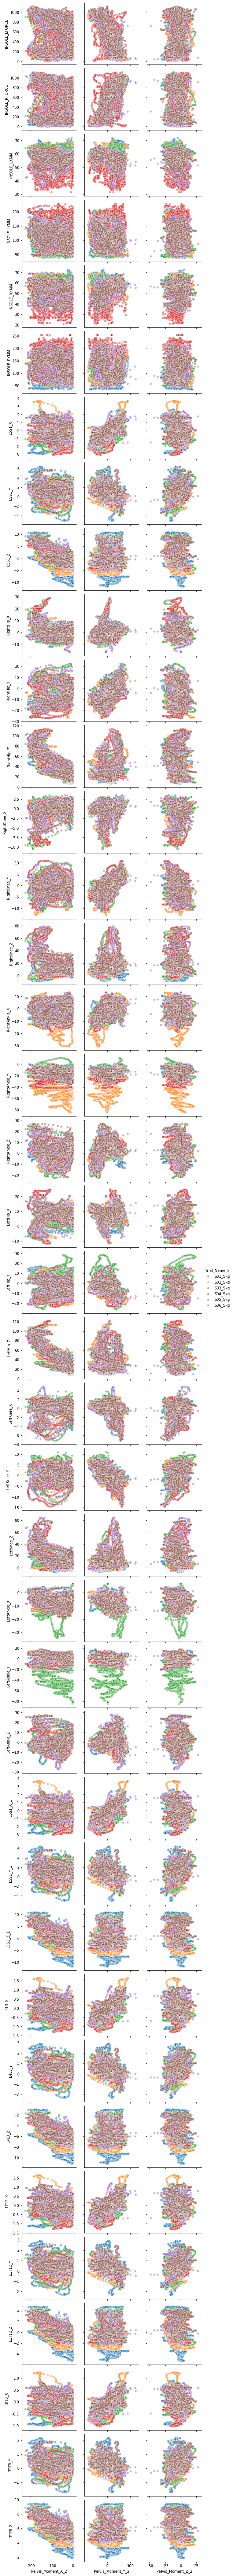

In [42]:
g = sns.pairplot(df_test, hue=trial_name, y_vars=feature_names, x_vars=target_names, plot_kws={'alpha': 0.5})

- Let's see the results with cross-validation (group k-fold)

In [59]:
for target_name in target_names:
    cv_model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor(max_iter=200))
    ])
    cv_scores = model_selection.cross_validate(
        cv_model, df[feature_names], df[target_name],
        scoring=("r2", "neg_root_mean_squared_error"),
        cv=model_selection.GroupKFold(n_splits=10).split(df[feature_names], df[target_name], groups=df[trial_name]))
    print(f'{target_name}: RMSE={-cv_scores["test_neg_root_mean_squared_error"].mean():.2f}, R2={cv_scores["test_r2"].mean():.3f}')

Pelvis_Moment_X_2: RMSE=20.71, R2=0.913
Pelvis_Moment_Y_2: RMSE=10.98, R2=0.852
Pelvis_Moment_Z_2: RMSE=6.93, R2=0.414
